In [1]:
import torch
import matplotlib
import matplotlib.pylab as plt
import torchaudio
from IPython.display import Audio, display

from torch.utils.data import DataLoader

from model import model
from datasets.avspeech import create_hparams, Spec2Audio, AVSpeech


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/home/christen/.local/lib/python3.6/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)

def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")
    


def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='lower', 
                       interpolation='none')

In [3]:
model_path = 'savedmodels/31a514ea0e63bfcd93305e908b4d74e4/9000_1624362309.pth'

hparams = create_hparams()
spec2audio = Spec2Audio(hparams)

net = model.get_network('test')
net.load_state_dict(torch.load(model_path, map_location=device)['state_dict'], strict=False)
net.eval()

net = net.to(device)

ds = AVSpeech('/media/ssd/christen-rnd/Experiments/Lip2Speech/Datasets/AVSpeech', mode='test', frame_length=3)

data = ds[0]
lower_faces, speech, melspec, face_crop = data
lower_faces = lower_faces.permute(1, 0, 2, 3)

lower_faces = lower_faces.to(device)
face_crop = face_crop.to(device)

mel_outputs, mel_outputs_postnet, _, alignments = net.inference(lower_faces.unsqueeze(0), face_crop.unsqueeze(0))
speechs = spec2audio(mel_outputs).cpu()

waveform = mel_outputs.float().cpu()[0]
audio = speechs.float().cpu()[0]

/home/christen/.local/lib/python3.6/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/home/christen/.local/lib/python3.6/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)
/home/christen/.local/lib/python3.6/site-packages/torch/functional.py:587: UserWarning: The function torch.irfft is deprecated and will be removed in a future PyTorch relea

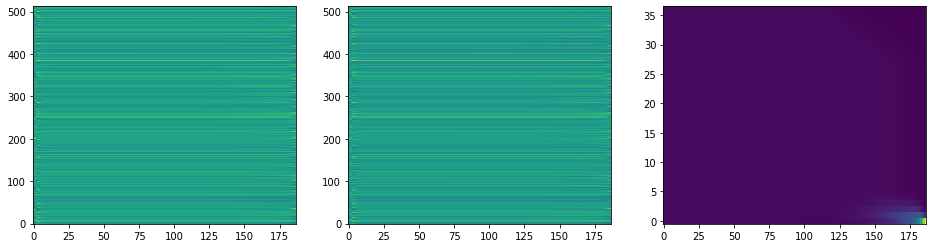

In [4]:
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

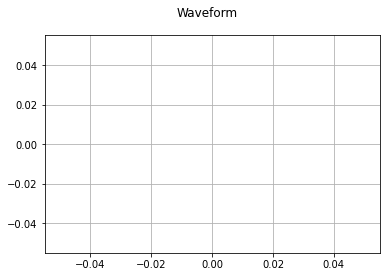

/home/christen/.local/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/christen/.local/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/christen/.local/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)


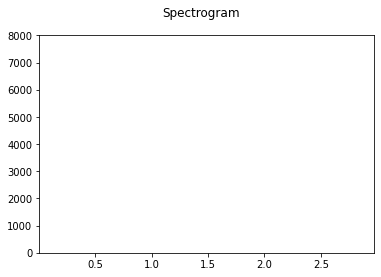

In [5]:
plot_waveform(audio.unsqueeze(0), hparams.sampling_rate)
plot_specgram(audio.unsqueeze(0), hparams.sampling_rate)
play_audio(audio.unsqueeze(0), hparams.sampling_rate)

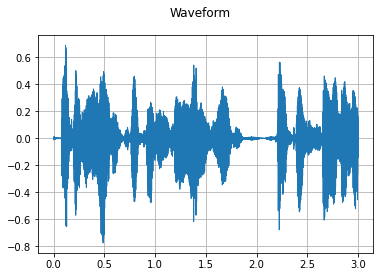

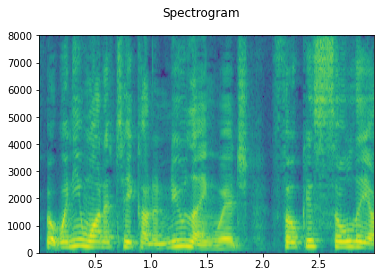

In [6]:
plot_waveform(speech, hparams.sampling_rate)
plot_specgram(speech, hparams.sampling_rate)
play_audio(speech, hparams.sampling_rate)

In [7]:
# import torch
# import zipfile
# import torchaudio
# from glob import glob

# device = torch.device('cpu')  # gpu also works, but our models are fast enough for CPU

# model, decoder, utils = torch.hub.load(repo_or_dir='snakers4/silero-models',
#                                        model='silero_stt',
#                                        language='en', # also available 'de', 'es'
#                                        device=device)
# (read_batch, split_into_batches,
#  read_audio, prepare_model_input) = utils  # see function signature for details

# # download a single file, any format compatible with TorchAudio (soundfile backend)
# torch.hub.download_url_to_file('https://opus-codec.org/static/examples/samples/speech_orig.wav',
#                                dst ='speech_orig.wav', progress=True)
# test_files = glob('speech_orig.wav')
# batches = split_into_batches(test_files, batch_size=10)
# input = prepare_model_input(read_batch(batches[0]),
#                             device=device)
# print(input)
# output = model(input)
# for example in output:
#     print(decoder(example.cpu()))